## Group Name : Unfiltered Commentary

- Raees Moosa : 2322203
- Oriinga Maudu : 2433303
- Tumi Jourdan : 2180153

In [23]:
import numpy as np
import imageio.v2 as imageio
from glob import glob
from skimage import img_as_float32
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
from typing import Tuple
import json
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import random
import math

In [24]:
path_pairs = list(zip(
natsorted(glob('./puzzle_corners_1024x768/images-1024x768/*.png')),
natsorted(glob('./puzzle_corners_1024x768/masks-1024x768/*.png')),
))
imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])

# Part 1 Finding Contours


1.1 `get_puzzle_contour`

1.2

In [25]:
def get_clockwise_contour(contours):
    if cv2.contourArea(contours,oriented=True)<0:
        return contours[::-1]
    return contours

1.1

In [26]:
def get_puzzle_contour(mask):
    mask_uint8 = cv2.convertScaleAbs(mask)
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = [c.reshape(-1, 2) for c in contours]
    
    # since we assume the contour closed has the largest area.
    max_contour = max(contours, key=cv2.contourArea)
    max_contour = get_clockwise_contour(max_contour.reshape(-1, 2))
    # some plots are not closed
    if not np.array_equal(max_contour[0], max_contour[-1]):
        # adding the first point to close the contour
        max_contour = np.vstack([max_contour, max_contour[0]])
    return max_contour

1.3 **how does `cv2.findContours` work and ow the oriented=True version
of cv2.contourArea detects orientation :**

\\


1.4 plot of the any 3 contours

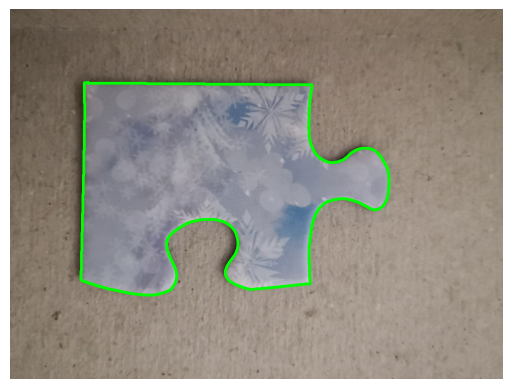

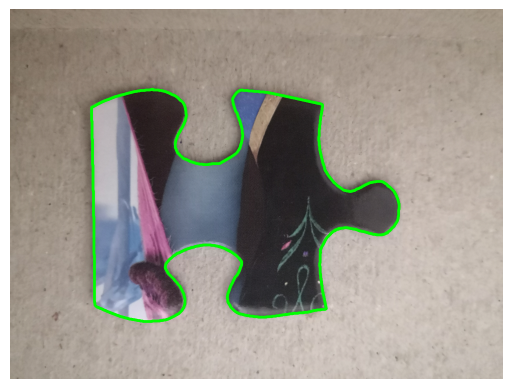

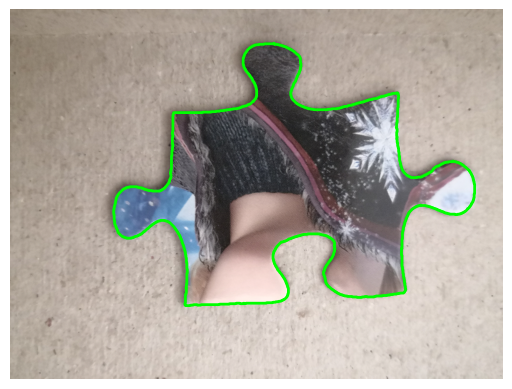

In [27]:
#Show Contours
for i in range(3):
    contour = get_puzzle_contour(msks[i])

   
    fig, ax = plt.subplots()

    #  image
    ax.imshow(imgs[i], cmap='gray')

    # contours
    x_coords, y_coords = zip(*contour)
    ax.plot(x_coords, y_coords, c='lime', linewidth=2)
    ax.axis('off')
    plt.show()


## Shape models

In [28]:
with open("./puzzle_corners_1024x768/corners.json", mode="r") as f:
    names, corner_ratios = json.load(f)

#Convert Ratios to coordinates
for picture in range(len(corner_ratios)):
    for points in range(len(corner_ratios[picture])):
        corner_ratios[picture][points]=[corner_ratios[picture][points][0]*1024,corner_ratios[picture][points][1]*768]    

**NOTE:** Using `cv2.CHAIN_APPROX_SIMPLE` is helpful since it only stores the endpoints of the lines that form the contour - this is what we need if we want to find the nearest point in the contour to the corner. makes finding the nearest contour easier.

In [29]:
def extract_sides(contour, corners):
    corner_indices=[]
    for corner in corners:
        #get distance
        corner_dists = np.linalg.norm(contour - corner, axis=-1)
        # using argmin to get the closest points since smaller distance
        nearest_idx = np.argmin(corner_dists)
        corner_indices.append(nearest_idx)

    corner_indices = sorted(corner_indices)
  

    

    side_contours = []
    for i in range(4):
        start_idx = corner_indices[i]
        end_idx = corner_indices[(i + 1) % 4]
        if start_idx < end_idx:
            side_contour = contour[start_idx:end_idx + 1]
        else:
            side_contour = np.concatenate([contour[start_idx:], contour[:end_idx + 1]])
        
        side_contours.append(side_contour)

    return side_contours




In [30]:
### helper to plot the contours
def plot_puzzle_piece(img,contour, corners, sides):
    corners = np.array(corners)
    # colors of quad and sides
    quad_color = (1.0, 1.0, 1.0)  
    side_colors = [(1.0, 0.75, 0.0),
                   
                   (0.0, 0.25, 1.0), 
                    (0.0, 1.0, 0.0), 
                    (1.0, 0.0, 0.0),] 
    
    
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    
    # contour for each side with different colors
    for i, side in enumerate(sides):
        # ide contour in its color
        plt.plot(side[:, 0], side[:, 1], color=side_colors[i], linewidth=2)

        # colored dot at the start of each side
        plt.scatter(side[0, 0], side[0, 1], color=side_colors[i], zorder=6, s=100)

        # white dots along the side
        # num_points = 10
        # sparse_indices = np.linspace(0, len(side) - 1, num_points, dtype=int)
        
        
        # plt.scatter(side[sparse_indices, 0], side[sparse_indices, 1], color='white', zorder=5, s=20)

    




    plt.show()

In [31]:
def plot_side(img_index):
    contour = get_puzzle_contour(msks[img_index])
    # print("contours\n",contours)
    
    sides = extract_sides(contour,corner_ratios[img_index])
    
    plot_puzzle_piece(imgs[img_index],contour, corner_ratios[img_index], sides)


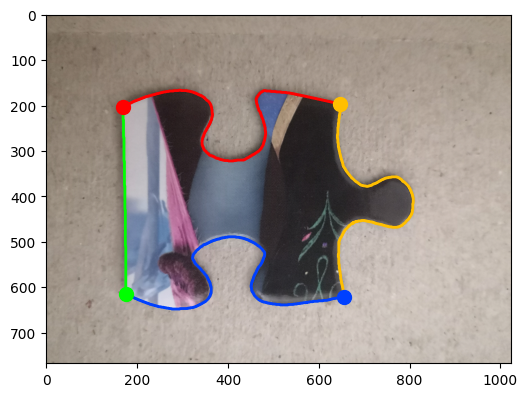

In [32]:
plot_side(1)

# NOTE 
had to comment out the plot in this function because it was messing the the plot for the ijnterpolation!!!

In [33]:
def transform_puzzle_side(contour): # contour is a side
    point1 = np.array(contour[0])
    point2 = np.array(contour[-1])
    line = np.array([point1,point2])

    midpoint = (point1 + point2)/2
    #print(midpoint)

    #Do translation
    translated_contour = contour - midpoint

    #scale
    length = np.linalg.norm(point2 - point1)
    scale_factor = 2.0/length
    scaled_contour = (translated_contour)* scale_factor

    #Do Rotation
    theta =np.arctan2(translated_contour[0][1],translated_contour[0][0])
    #print(theta)
    rotation_matrix = np.array([[np.cos(-theta), -np.sin(-theta)],
                                [np.sin(-theta),  np.cos(-theta)]])

    rotated_contour = (rotation_matrix @ scaled_contour.T).T

    # x_coords = rotated_contour[:, 0]
    # y_coords = rotated_contour[:, 1]

    # # Create the scatter plot
    # plt.scatter(x_coords, y_coords)

    # # Optional: Add titles and labels
    # plt.title('Scatter Plot of Points')
    # plt.xlabel('X-axis')
    # plt.ylabel('Y-axis')
    # plt.show()
    return rotated_contour
    # Show the plot
contour = get_puzzle_contour(msks[1])

        
sides = extract_sides(contour,corner_ratios[1])
side_0 = transform_puzzle_side(sides[0])


In [34]:
def even_spaced_contour(contour, num_points=64):
    #distance between consecutive points
    diffs = np.diff(contour, axis=0)
    segment_lengths = np.sqrt((diffs**2).sum(axis=1)) #just the euclidean

    #cumultive len init to 0
    cumulative_lengths = np.insert(np.cumsum(segment_lengths),0,0)

    #normalisation of len
    total_length = cumulative_lengths[-1] #since cumulative las it total
    cumulative_ratios = cumulative_lengths/ total_length

    #to space evenly
    spacing = np.linspace(0,1,num_points)

    #interpolation  
    x_new = np.interp(spacing, cumulative_ratios, contour[:,0])
    y_new = np.interp(spacing, cumulative_ratios, contour[:,1])

    new_contour = np.vstack((x_new,y_new)).T

    return new_contour

In [35]:
new_side = even_spaced_contour(side_0)

In [36]:
def plot_normalised(contour, corners, num_sides=4):
    sides = extract_sides(contour,corners)

    plt.figure(figsize=(8, 8))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)

    side_colors = [(1.0, 0.75, 0.0),
                   (0.0, 0.25, 1.0), 
                    (0.0, 1.0, 0.0), 
                    (1.0, 0.0, 0.0),]  
    for i in range(num_sides):
        side = transform_puzzle_side(sides[i])
        simplified_side = even_spaced_contour(side, 64) #said to use 10 points for a simplified plot
        plt.plot(simplified_side[:, 0], simplified_side[:, 1], color=side_colors[i], linestyle='-', linewidth=1, marker=None)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

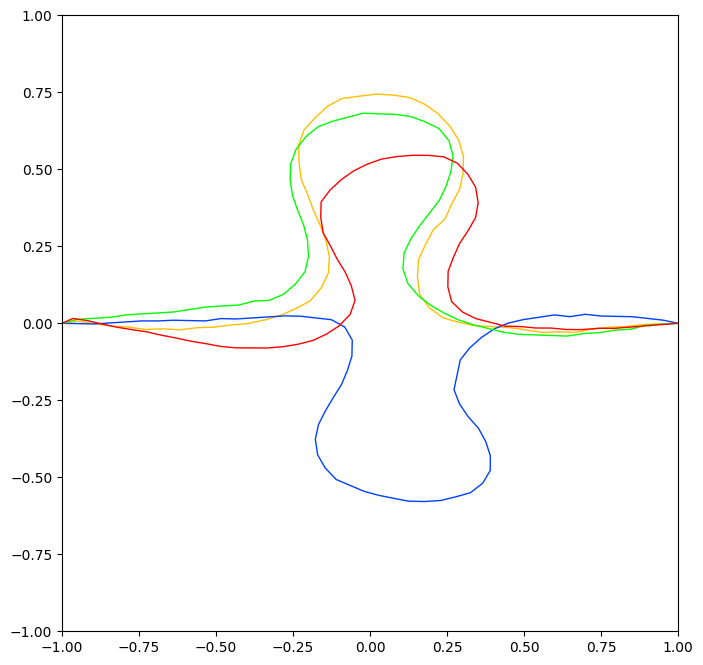

In [78]:
contour = get_puzzle_contour(msks[2])
plot_normalised(contour, corner_ratios[2])

## 3 Match Shape Models


3.1 Before we can apply these rules, we need to know which sides of pieces are flat so we can determine if
they should be matched or not, and so that we can determine if a piece is an interior piece (no flat sides),
edge piece (1 flat side), corner piece (2 flat sides) or invalid piece (3 or 4 flat sides).
Note that with side information, you could solve for possible the widths and heights of the puzzle in
terms of pieces. Taking into account the number of pieces along the perimeter and the total area.
Code is_flat_side(contour, min_ratio=0.9) that checks if the distance cont_dist be-
tween the two endpoints of a non-closed contour is approximately equal to the entire length cont_len
of the contour. If cont_dist/cont_len >= min_ratio then the side should be considered flat.
Hint: np.linalg.norm and cv2.arcLength7 called with closed=False may come in handy.

In [38]:
def is_flat_side(contour, min_ratio=0.9):
    contour = contour.reshape((-1, 1, 2))
    contour = contour.astype(np.float32)
    point_to_point = np.array([contour[0], contour[-1]])
    point_to_point_length = cv2.arcLength(point_to_point,closed=False)
    total_length = cv2.arcLength(contour,closed=False)

    #print("Straight:",point_to_point_length)
    #print("Curve:",total_length)
    if(point_to_point_length/total_length <min_ratio):
        return False
    
    return True
    

def flat_sides(contour, corners, num_sides=4):
    sides = extract_sides(contour,corners)
    
    for i in range(num_sides):
        side = transform_puzzle_side(sides[i])
        simplified_side = even_spaced_contour(side, 64) #said to use 10 points for a simplified plot
        is_flat_side(simplified_side)
        
contour = get_puzzle_contour(msks[1])


flat_sides(contour,corner_ratios[1])

In [83]:
class Piece:
    """
    A class for each piece
        Attributes:
        contour 
        corners 
        sides : extracted sides normalized and translated.
        flat_sides (bool): 1d matrix of which sides are flat
        num_flat (int) : the number of flat sides        
    """
    def __init__(self,mask,corners) -> None:
        self.contour = get_puzzle_contour(mask)
        self.corners = corners
        self.sides = extract_sides(self.contour,corners)
        self.sides_objects:Side = [Side]*4 
        # normalize,translate sides, determine flat and not flat sides
        for i in range(4):
            side = transform_puzzle_side(self.sides[i])
            self.sides[i] = even_spaced_contour(side, 64) #said to use 10 points for a simplified plot            
            self.sides_objects[i] = Side(self,self.sides[i])
        self.num_flat = np.sum(self.flat_sides)

        self.interior_piece = self.is_interior_piece(self.sides_objects)
    
    def is_interior_piece(self,side_objects):
        interior:bool = True
        for x in (side_objects):
            if(x.is_flat == True):
                interior = False
                return interior
        return interior

class Side :
    """
    A class for each piece
        Attributes:
        Piece : A refrence to the parent piece class.
        Side : contour of the side.
        is_flat (bool) : Boolean flag for if the side is flat.
        protruding (bool) :     
    """
    def __init__(self,piece,contour):
        self.piece = piece
        self.contour = contour
        self.rotated_side = self.rotate_side(self.contour)
        self.is_flat = is_flat_side(self.contour)
        self.protruding = self.determine_protruding(self.contour,-0.25)
        pass

    def plot_side(self):
        plt.plot(self.contour[:, 0], self.contour[:, 1], linestyle='-', linewidth=1, marker=None)
        plt.show()

    def determine_protruding(self,contour,threshold):
        if(np.min(contour[:,1])<threshold):
            return False
        else:
            return True
    def rotate_side(self,contour):
        reversed_side = (contour * -1)[::-1]
        return reversed_side

    def __str__(self):
        return f"Side(is_flat={self.is_flat}, protruding={self.protruding})"

piece = Piece(msks[0],corner_ratios[0])
for x in range(len(piece.sides_objects)):
    print(piece.sides_objects[x])

Side(is_flat=False, protruding=True)
Side(is_flat=False, protruding=False)
Side(is_flat=True, protruding=True)
Side(is_flat=True, protruding=True)


In [85]:
def get_nearest_neighbour_model(rotated_sides):
    knn = NearestNeighbors(n_neighbors=1,algorithm="brute")
    return knn.fit(rotated_sides)

In [86]:
def plot_graph(V, E, seed=42):
    random.seed(seed) # graphs are randomly plotted
    np.random.seed(seed) # graphs are randomly plotted
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    nx.draw_kamada_kawai(G, with_labels=True)
    plt.show()

C:\Users\willi\AppData\Local\Temp\ipykernel_89492\1705311637.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E = [(math.floor(i/4),math.floor(indeces[i]/4)) for i in range(len(indeces))]


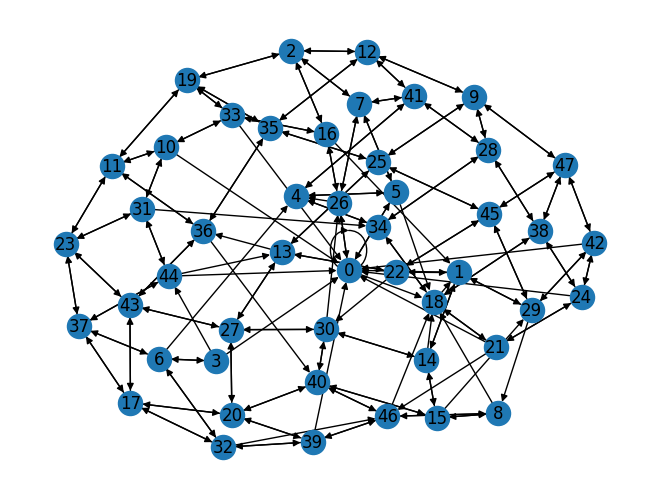

In [87]:
pieces_array = []
rotated_sides = []
side_features = []
for image in range(len(imgs)):
    piece = Piece(msks[image],corner_ratios[image])
    pieces_array.append(piece)
    for i in piece.sides_objects:
        side_features.append(i.contour.flatten()) ##Flatten to give a 1D feature array
        rotated_sides.append(i.rotated_side.flatten()) ##Flatten to give a 1D feature array

knn = get_nearest_neighbour_model(rotated_sides)

distances , indeces = knn.kneighbors(side_features)
V = [i for i in range(len(pieces_array))]
E = [(math.floor(i/4),math.floor(indeces[i]/4)) for i in range(len(indeces))] 

plot_graph(V,E)